# Facies Classification Solution By Team_BGC

Cheolkyun Jeong and Ping Zhang From Team_BGC

## Import Header

In [28]:
##### import basic function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

## 1. Data Prepocessing

1) Filtered data preparation

After the initial data validation, we figure out the NM_M input is a key differentiator to group non-marine stones (sandstone, c_siltstone, and f_siltstone) and marine stones (marine_silt_shale, mudstone, wakestone, dolomite, packstone, and bafflestone) in the current field. Our team decides to use this classifier aggressively and prepare a filtered dataset which cleans up the outliers.

In [29]:
# Input file paths
facies_vector_path = 'facies_vectors.csv'
train_path = 'training_data.csv'
test_path = 'validation_data_nofacies.csv'
# Read training data to dataframe
#training_data = pd.read_csv(train_path)

Using Full data to train

In [30]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors

In [31]:
training_data = pd.read_csv(facies_vector_path)

In [32]:
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

# Fitering out some outliers
j = []
for i in range(len(training_data)):
    if ((training_data['NM_M'].values[i]==2)and ((training_data['Facies'].values[i]==1)or(training_data['Facies'].values[i]==2)or(training_data['Facies'].values[i]==3))):
        j.append(i)
    elif((training_data['NM_M'].values[i]==1)and((training_data['Facies'].values[i]!=1)and(training_data['Facies'].values[i]!=2)and(training_data['Facies'].values[i]!=3))):
        j.append(i)

training_data_filtered = training_data.drop(training_data.index[j])
print(np.shape(training_data_filtered))

(4095, 12)


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Add Missing PE by following AR4 Team

In [33]:
#X = training_data_filtered[feature_names].values
# Testing without filtering
X = training_data[feature_names].values

reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
# DataImpAll = training_data_filtered[feature_names].copy()
DataImpAll = training_data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

## 2. Feature Selection

Log Plot of Facies

### Filtered Data

SS      268
CSiS    940
FSiS    780
SiSh    271
MS      296
WS      582
D       141
PS      686
BS      185
Name: Facies, dtype: int64

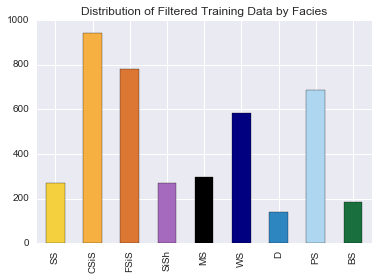

In [34]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
#facies_counts_filtered = training_data_filtered['Facies'].value_counts().sort_index()
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
#facies_counts_filtered.index = facies_labels
facies_counts.index = facies_labels

#facies_counts_filtered.plot(kind='bar',color=facies_colors, 
#                   title='Distribution of Filtered Training Data by Facies')
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Filtered Training Data by Facies')
#facies_counts_filtered
#training_data_filtered.columns
#facies_counts_filtered

training_data.columns
facies_counts

### Filtered facies

In [35]:
#correct_facies_labels_filtered = training_data_filtered['Facies'].values
#feature_vectors_filtered = training_data_filtered.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

In [36]:
from sklearn import preprocessing
#scaler_filtered = preprocessing.StandardScaler().fit(X)
#scaled_features_filtered = scaler_filtered.transform(X)
scaler = preprocessing.StandardScaler().fit(X)
scaled_features = scaler.transform(X)

In [38]:
from sklearn.cross_validation import train_test_split
#X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
#        scaled_features_filtered, correct_facies_labels_filtered, test_size=0.3, random_state=16)

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.3, random_state=16)

In [39]:
X_train_full, X_test_zero, y_train_full, y_test_full = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.0, random_state=42)

## 3. Prediction Model

Accuracy

In [40]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [41]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

SVM

In [42]:
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict
from classification_utilities import display_cm, display_adj_cm

In [43]:
from sklearn import svm
clf_filtered = svm.LinearSVC(random_state=23) 

In [44]:
#clf_filtered.fit(X_train_filtered, y_train_filtered)
clf_filtered.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=23, tol=0.0001,
     verbose=0)

In [45]:
#predicted_labels_filtered = clf_filtered.predict(X_test_filtered)
predicted_labels = clf_filtered.predict(X_test)

SVM for filtered data model

## 4. Result Analysis

In [48]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

In [49]:
X_unknown = scaler_filtered.transform(well_features)

# Using all data and optimize parameter to train the data
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train_full, y_train_full)
#clf_filtered.fit(X_train_filtered, y_train_filtered)
y_unknown = clf_filtered.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data
well_data.to_csv('predict_result_svm_full_data.csv')

## 5. Using Tensorflow

Filtered Data Model

In [50]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

# Specify that all features have real-value data
feature_columns_filtered = [tf.contrib.layers.real_valued_column("", dimension=7)]

# Build 3 layer DNN with 7, 17, 10 units respectively.
classifier_filtered = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns_filtered,
                                            hidden_units=[7, 17, 10],
                                            n_classes=10)

# Fit model.
#classifier_filtered.fit(x=X_train_filtered,y=y_train_filtered,steps=5000)
#y_predict_filtered = []
#predictions = classifier_filtered.predict(x=X_test_filtered)

classifier_filtered.fit(x=X_train,y=y_train,steps=5000)
y_predict = []
predictions = classifier_filtered.predict(x=X_test)


for i, p in enumerate(predictions):
    y_predict.append(p)
    #print("Index %s: Prediction - %s, Real - %s" % (i + 1, p, y_test_filtered[i]))

# Evaluate accuracy.
#accuracy_score_filtered = classifier_filtered.evaluate(x=X_test_filtered, y=y_test_filtered)["accuracy"]
#print('Accuracy: {0:f}'.format(accuracy_score_filtered))
accuracy_score = classifier_filtered.evaluate(x=X_test, y=y_test)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

cv_conf_dnn = confusion_matrix(y_test, y_predict)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_dnn))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_dnn, adjacent_facies))
display_cm(cv_conf_dnn, facies_labels,display_metrics=True, hide_zeros=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000013C74C50>, 'tf_random_seed': None, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, 'keep_checkpoint_every_n_hours': 10000, 'keep_checkpoint_max': 5, 'save_checkpoints_secs': 600, '_environment': 'local', 'save_checkpoints_steps': None, 'save_summary_steps': 100, '_task_id': 0, '_is_chief': True, '_task_type': None}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

Result from DNN

In [53]:
classifier_filtered.fit(x=X_train_full,
               y=y_train_full,
               steps=10000)
predictions = classifier_filtered.predict(X_unknown)
y_predict_filtered = []
for i, p in enumerate(predictions):
    y_predict_filtered.append(p)
well_data['Facies'] = y_predict_filtered
well_data
well_data.to_csv('predict_result_dnn_full_data.csv')

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using

In [27]:
#export_dir_path = 'd:\\'
#classifier_filtered.export(export_dir_path)

Instructions for updating:
The signature of the input_fn accepted by export is changing to be consistent with what's used by tf.Learn Estimator's train/evaluate. input_fn (and in most cases, input_feature_key) will become required args, and use_deprecated_input_fn will default to False and be removed altogether.
Instructions for updating:
The signature of the input_fn accepted by export is changing to be consistent with what's used by tf.Learn Estimator's train/evaluate. input_fn and (and in most cases, input_feature_key) will become required args. use_deprecated_input_fn will default to False and be removed. default_batch_size will also be removed since it will now be a part of the input_fn.
Instructions for updating:
The signature of the input_fn accepted by export is changing to be consistent with what's used by tf.Learn Estimator's train/evaluate. input_fn and (and in most cases, input_feature_key) will become required args. use_deprecated_input_fn will default to False and be remo

b'd:\\00015000'